In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.metrics import mean_squared_error
import math

warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

def feature_stock_data(file_path):
    data = pd.read_csv(file_path)
    newfeatures = pd.DataFrame()
    newfeatures['Target'] = data['Close'].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
    newfeatures['Target'].fillna(0, inplace=True)
    data = data.shift(1)
    data['Target'] = newfeatures['Target']
    return data.iloc[1:]

def logistic_regression_analysis(data):
    # Predictors and Target
    predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
    X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=5)

    # Hyperparameter selection for Logistic Regression
    def select_hyperparameters_logistic_regression(X_train, y_train):
        model = LogisticRegression()
        space = {
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['none', 'l1', 'l2', 'elasticnet'],
            'C': loguniform(1e-5, 100)
        }
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return result.best_params_

    # Logistic Regression with hyperparameters
    def logistic_regression_hyperparameter(X_train, y_train, X_test, y_test, params):
        model = LogisticRegression(C=params['C'], solver=params['solver'], penalty=params['penalty'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']), annot=True, fmt='d', cmap="YlGnBu")
        plt.show()
        # Tính toán RMSE
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        return accuracy_score(y_test, y_pred), rmse

    best_params_lr = select_hyperparameters_logistic_regression(X_train, y_train)
    accuracy_logistic, rmse_logistic = logistic_regression_hyperparameter(X_train, y_train, X_test, y_test, best_params_lr)
    print("Logistic Regression Accuracy (default predictors):", round(accuracy_logistic * 100, 2), "%")
    print("Logistic Regression RMSE:", rmse_logistic)

def random_forest_analysis(data):
    # Predictors and Target
    predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
    X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=5)

    # Hyperparameter selection for Random Forest
    def select_hyperparameters_random_forest(X_train, y_train):
        model = RandomForestClassifier()
        space = {
            'n_estimators': [10, 100, 1000],
            'max_features': ['sqrt', 'log2']
        }
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return result.best_params_

    # Random Forest with hyperparameters
    def random_forest_hyperparameter(X_train, y_train, X_test, y_test, params):
        model = RandomForestClassifier(n_estimators=params['n_estimators'], max_features=params['max_features'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']), annot=True, fmt='d', cmap="YlGnBu")
        plt.show()
        # Tính toán RMSE
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        return accuracy_score(y_test, y_pred), rmse

    best_params_rf = select_hyperparameters_random_forest(X_train, y_train)
    accuracy_rf, rmse_rf = random_forest_hyperparameter(X_train, y_train, X_test, y_test, best_params_rf)
    print("Random Forest Accuracy (default predictors):", round(accuracy_rf * 100, 2), "%")
    print("Random Forest RMSE:", rmse_rf)



    LSTM

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import math

# Data preparation function
def feature_stock_data(file_path):
    data = pd.read_csv(file_path)
    newfeatures = pd.DataFrame()
    newfeatures['Target'] = data['Close'].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
    newfeatures['Target'].fillna(0, inplace=True)
    data = data.shift(1)
    data['Target'] = newfeatures['Target']
    return data.iloc[1:]

# Prepare data for LSTM
def prepare_lstm_data(data, predictors, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[predictors].iloc[i-time_steps:i].values)
        y.append(data['Target'].iloc[i])
    return np.array(X), np.array(y)

# LSTM model function
def lstm_model_analysis(data):
    predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
    time_steps = 10
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[predictors])

    data[predictors] = scaled_data
    X, y = prepare_lstm_data(data, predictors, time_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    # LSTM Model
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(units=64))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.1, verbose=1)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Confusion matrix and accuracy
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']), annot=True, fmt='d', cmap="YlGnBu")
    plt.show()

    # Calculate metrics
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    print("LSTM Model Accuracy:", round(accuracy * 100, 2), "%")
    print("LSTM Model RMSE:", rmse)


    ARIMA

In [83]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import math

# Data preparation function
def feature_stock_data(file_path):
    data = pd.read_csv(file_path)
    newfeatures = pd.DataFrame()
    newfeatures['Target'] = data['Close'].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
    newfeatures['Target'].fillna(0, inplace=True)
    data = data.shift(1)
    data['Target'] = newfeatures['Target']
    return data.iloc[1:]

# ARIMA model function
def arima_model_analysis(data):
    # Convert 'Date' column to datetime format and remove timezone information
    data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.replace(tzinfo=None))
    data.set_index('Date', inplace=True)
    df = data[['Close']]

    # Handle NaN values by filling them
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Split the data into training and testing sets
    train_size = int(len(df) * 0.8)
    train, test = df[:train_size], df[train_size:]

    # Tune ARIMA parameters
    p = d = q = range(0, 3)
    pdq = [(x, y, z) for x in p for y in d for z in q]
    best_aic = float("inf")
    best_order = None
    best_mdl = None

    for param in pdq:
        try:
            tmp_mdl = ARIMA(train, order=param).fit()
            if tmp_mdl.aic < best_aic:
                best_aic = tmp_mdl.aic
                best_order = param
                best_mdl = tmp_mdl
        except:
            continue

    print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

    # Fit the ARIMA model with the best parameters
    model = ARIMA(train, order=best_order)
    model_fit = model.fit()

    # Make predictions
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end, typ='levels')

    # Handle NaN values in predictions
    predictions = predictions.fillna(method='ffill').fillna(method='bfill')
    
    # Merge predictions with original data
    test['Predicted_Close'] = predictions
    test['Predicted_Target'] = test['Predicted_Close'].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
    test['Predicted_Target'].fillna(0, inplace=True)

    # Handle NaN values in targets
    test['Predicted_Target'] = test['Predicted_Target'].fillna(0)
    
    # Evaluate the model
    y_test = data['Target'].iloc[train_size:].values
    y_pred = test['Predicted_Target'].values

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']), annot=True, fmt='d', cmap="YlGnBu")
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate metrics
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    print("ARIMA Model Accuracy:", round(accuracy * 100, 2), "%")
    print("ARIMA Model RMSE:", rmse)



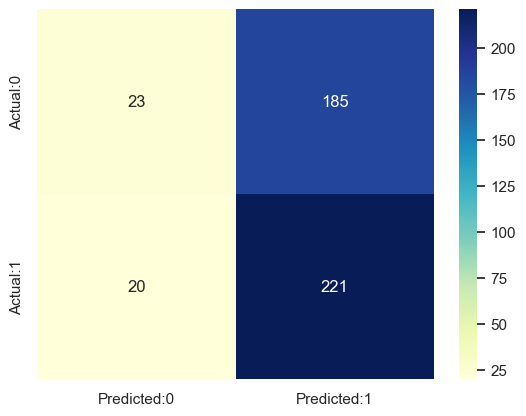

Logistic Regression Accuracy (default predictors): 54.34 %
Logistic Regression RMSE: 0.6756997527763381


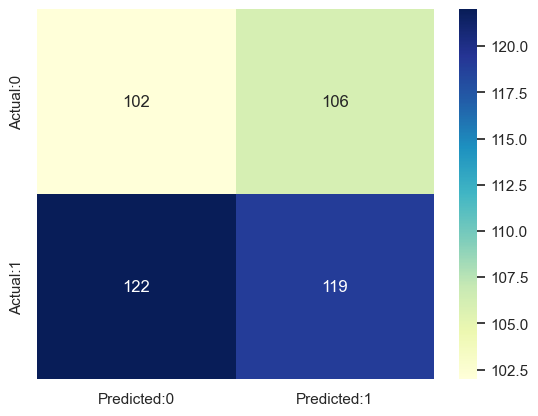

Random Forest Accuracy (default predictors): 49.22 %
Random Forest RMSE: 0.7125974320910209
Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.2519 - val_loss: 0.2503
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2504 - val_loss: 0.2481
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2505 - val_loss: 0.2489
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2504 - val_loss: 0.2481
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2500 - val_loss: 0.2492
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2499 - val_loss: 0.2490
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2502 - val_loss: 0.2488
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2501 - val_loss: 0.2480
Epoch 9/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2504 - val_loss: 0.2494
Epoch 10/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2499 - val_loss: 0.2488
Epoch 11/100
201/201 ━━━━━━━━━━━━━━

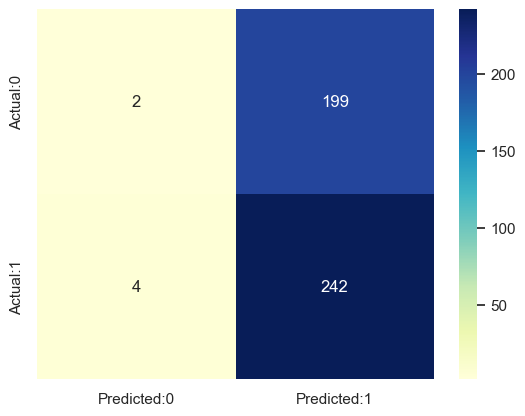

LSTM Model Accuracy: 54.59 %
LSTM Model RMSE: 0.6738981395291502
Best ARIMA order: (1, 1, 0) with AIC: -11422.678644413709


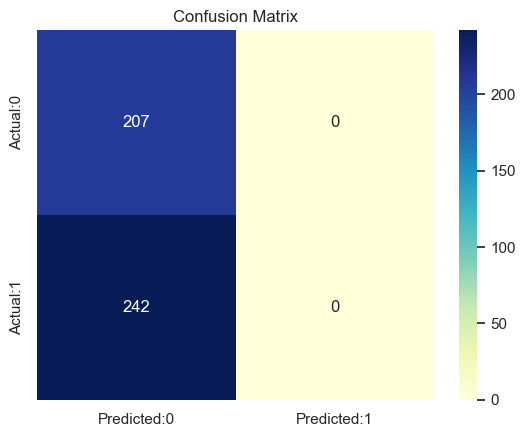

ARIMA Model Accuracy: 46.1 %
ARIMA Model RMSE: 0.7341495086925999


In [87]:
data = feature_stock_data('../clean_data/clean_dataMETA.csv')
logistic_regression_analysis(data)
random_forest_analysis(data)
lstm_model_analysis(data)
arima_model_analysis(data)